In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import pickle
import re
import nltk

In [2]:
# Read in Dataset from file
spotify_df = pd.read_pickle("spotify_df.pkl")

In [3]:
# Change data types of the following Columns, duration_ms -> int, instrumentalness -> float, 
# key -> int, mode -> int, time_signature -> int
spotify_df = spotify_df.astype({'duration_ms': int, 'instrumentalness': float,'key': int,'mode': int,'time_signature': int})

In [4]:
#remove track with missing lyric data
df_filtered = spotify_df.loc[spotify_df.lyrics.apply(type) != float]

In [5]:
#save filtered df as new df
spotify_df = df_filtered.copy()

### Removing Outliers


In [6]:
Q1 = spotify_df.duration_ms.quantile(0.25)
Q3 = spotify_df.duration_ms.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

64547.25


In [7]:
df_drop_outlier = spotify_df[~((spotify_df.duration_ms < (Q1 - 1.5 * IQR)) |(spotify_df.duration_ms> (Q3 + 1.5 * IQR)))]


In [8]:
#save outlier removed df as new df
spotify_df = df_drop_outlier.copy()

In [9]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22493 entries, 0 to 26560
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            22493 non-null  object 
 1   artist              22493 non-null  object 
 2   artist_id           22493 non-null  object 
 3   album               22493 non-null  object 
 4   trackName           22493 non-null  object 
 5   root genre          22493 non-null  object 
 6   sub genre           22493 non-null  object 
 7   acousticness        22493 non-null  float64
 8   danceability        22493 non-null  float64
 9   duration_ms         22493 non-null  int64  
 10  energy              22493 non-null  float64
 11  instrumentalness    22493 non-null  float64
 12  key                 22493 non-null  int64  
 13  liveness            22493 non-null  float64
 14  loudness            22493 non-null  float64
 15  mode                22493 non-null  int64  
 16  spee

### Feature Enginering 

 - Build new features out of the track lyrics for use in classifier modles 
 
![text_feature](../media/textclassifier.png)

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


stemmer = WordNetLemmatizer()

stop_words = stopwords.words('english')
newStopWords = ['know','like','said','love','see','one']
stop_words.extend(newStopWords)
stop_words = set(stop_words)

def prepare_lyrics(text_str):
    # Remove newline char
    text_str = re.sub(r'\n', ' ', text_str)
    # remove all single char
    text_str = re.sub(r'\s+[a-zA-Z]\s+', ' ', text_str)
    # Remove single characters from the start, 
    text_str = re.sub(r'\^[a-zA-Z]\s+', ' ', text_str) 
    # Substituting multiple spaces with single space
    text_str = re.sub(r'\s+', ' ', text_str, flags=re.I)
    #Make Lowercase 
    text_str = text_str.lower()
    
    #tokenize
    text_vec = text_str.split()
    return(text_vec)

[nltk_data] Downloading package stopwords to /home/seanr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/seanr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
def stop_lemm(text_vec):
        
    #remove stopwords
    text_vec_stop_rm = [word for word in text_vec if not word in stop_words]
                
    #Lemmatization 
    lyric_vector = [stemmer.lemmatize(word) for word in text_vec_stop_rm]
    return (lyric_vector)


In [11]:
#applying prepare_lyrics to all lyrics in the dataframe 
from pandarallel import pandarallel
pandarallel.initialize(progress_bar = True)

spotify_df['lyrics_vector'] = spotify_df['lyrics'].parallel_apply(prepare_lyrics)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


#### Part of Speach Features

In [26]:
spotify_df['lyrics_lemm'] = spotify_df['lyrics_vector'].parallel_apply(stop_lemm)

In [12]:
#Part of Speach tagging 
nltk.download('averaged_perceptron_tagger')
def pos_tagging(text_vector):
    pos_tagged_vec = nltk.pos_tag(text_vector)
    return pos_tagged_vec


def count_noun(pos_tagged_vec):
    return sum(1 for word, pos in pos_tagged_vec if pos.startswith('NN'))
def count_verb(pos_tagged_vec):
    return sum(1 for word, pos in pos_tagged_vec if pos.startswith('VB'))
def count_adverb(pos_tagged_vec):
    return sum(1 for word, pos in pos_tagged_vec if pos.startswith('RB'))
def count_adjective(pos_tagged_vec):
    return sum(1 for word, pos in pos_tagged_vec if pos.startswith('JJ'))
def count_foreign(pos_tagged_vec):
    return sum(1 for word, pos in pos_tagged_vec if pos.startswith('FW'))


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/seanr/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [13]:
pandarallel.initialize()
spotify_df['pos_tagging'] = spotify_df['lyrics_vector'].parallel_apply(pos_tagging)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [16]:
spotify_df['nouns'] = spotify_df['pos_tagging'].parallel_apply(count_noun)

In [18]:
spotify_df['verbs'] = spotify_df['pos_tagging'].parallel_apply(count_verb)

In [19]:
spotify_df['adverbs'] = spotify_df['pos_tagging'].parallel_apply(count_adverb)

In [20]:
spotify_df['adjectives'] = spotify_df['pos_tagging'].parallel_apply(count_adjective)

In [21]:
spotify_df['foreign_count'] = spotify_df['pos_tagging'].parallel_apply(count_foreign)

In [15]:
# Source Of Profanity List
#https://github.com/RobertJGabriel/Google-profanity-words
# https://raw.githubusercontent.com/RobertJGabriel/Google-profanity-words/master/list.txt
import urllib

url = "https://raw.githubusercontent.com/RobertJGabriel/Google-profanity-words/master/list.txt"

file = urllib.request.urlopen(url)
profainity_list = []
for line in file:
    word = line.decode("utf-8")
    word = re.sub(r'\n', '', word)
    profainity_list.append(word)


In [22]:
def profanity_count(text_vec,profane=profainity_list):
    c = sum(elm in text_vec for elm in profane)
    return c    

In [23]:
spotify_df['profanity_count'] = spotify_df['lyrics_vector'].parallel_apply(profanity_count)

In [24]:
lyric_text_features = ['nouns','verbs','adverbs','adjectives','foreign_count','profanity_count']
spotify_df.groupby('root genre')[lyric_text_features].mean()

nouns       verbs     adverbs  adjectives  foreign_count  \
root genre                                                                   
country      280.384360  172.340882   44.422403   96.034118       1.608998   
edm         1653.127207  940.214606  234.973062  532.708471      25.084406   
pop          506.651913  258.176756   60.609081  157.084238      13.846374   
r&b          647.351177  348.727298   86.717209  193.085202       5.727018   
rap          500.080690  267.424674   62.992771  154.630131       7.107743   
rock         462.089915  279.203704   73.869255  158.897813       3.764168   

            profanity_count  
root genre                   
country            0.537742  
edm                2.373242  
pop                0.938035  
r&b                1.441704  
rap                4.975979  
rock               0.808121

#### Sentiment Analysis 

In [3]:
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
Sentiment = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/seanr/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/seanr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def lyric_sentiment(lyric_text):
    #Break the song lyrics into sentences or lines 
    #lines_list = tokenize.sent_tokenize(lyric_text)
    lines_list = lyric_text.split('\n')
    #lines_list = [lyric_text]
    total = []
    for line in lines_list:
        line_sentiment = Sentiment.polarity_scores(line)
        total.append(line_sentiment['compound'])
    return(sum(total)/len(total))
    
    
test = spotify_df['lyrics'][100]

lyric_sentiment(test)

0.22360769230769234

In [5]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar = True)
spotify_df['lyrics_sentiment'] = spotify_df['lyrics'].parallel_apply(lyric_sentiment)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [36]:
#extract genre vectors 
import itertools

pop_lyrics = spotify_df.lyrics_vector[spotify_df['root genre'] == 'pop']
rap_lyrics = spotify_df.lyrics_vector[spotify_df['root genre'] == 'rap']
edm_lyrics = spotify_df.lyrics_vector[spotify_df['root genre'] == 'edm']
rnb_lyrics = spotify_df.lyrics_vector[spotify_df['root genre'] == 'r&b']
country_lyrics = spotify_df.lyrics_vector[spotify_df['root genre'] == 'country']
rock_lyrics = spotify_df.lyrics_vector[spotify_df['root genre'] == 'rock']

#flattten to one vector for the DTM
pop_lyrics_flatten =  " ".join(itertools.chain(*pop_lyrics))
rap_lyrics_flatten = " ".join(itertools.chain(*rap_lyrics))
edm_lyrics_flatten = " ".join(itertools.chain(*edm_lyrics))
rnb_lyrics_flatten = " ".join(itertools.chain(*rnb_lyrics))
country_lyrics_flatten = " ".join(itertools.chain(*country_lyrics))
rock_lyrics_flatten = " ".join(itertools.chain(*rock_lyrics))



In [37]:
from wordcloud import WordCloud


word_cloud_pop = WordCloud(width=600, height=600, max_words=175,colormap='Pastel1').generate(pop_lyrics_flatten)



In [30]:
word_cloud_all = WordCloud(width=1000, height=1000, max_words=175,colormap='Pastel1').generate(all_lycirs)

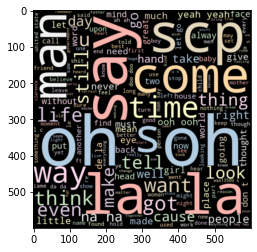

In [38]:
plt.imshow(word_cloud_pop, interpolation='bilinear')
plt.show()

#### Save New Features and dataframe 

In [7]:
spotify_df.to_pickle("spotify_df_feature.pkl")

### Selecting our Feature Data 

Using what we learned during EDA, we can select the following audio features to be used in the model building process 

 -  Because Loudness and Energy were highly correlated, and there was minimal variation in loudness across the different genres, it will be dropped
 

In [2]:
spotify_df = pd.read_pickle("spotify_df_feature.pkl")

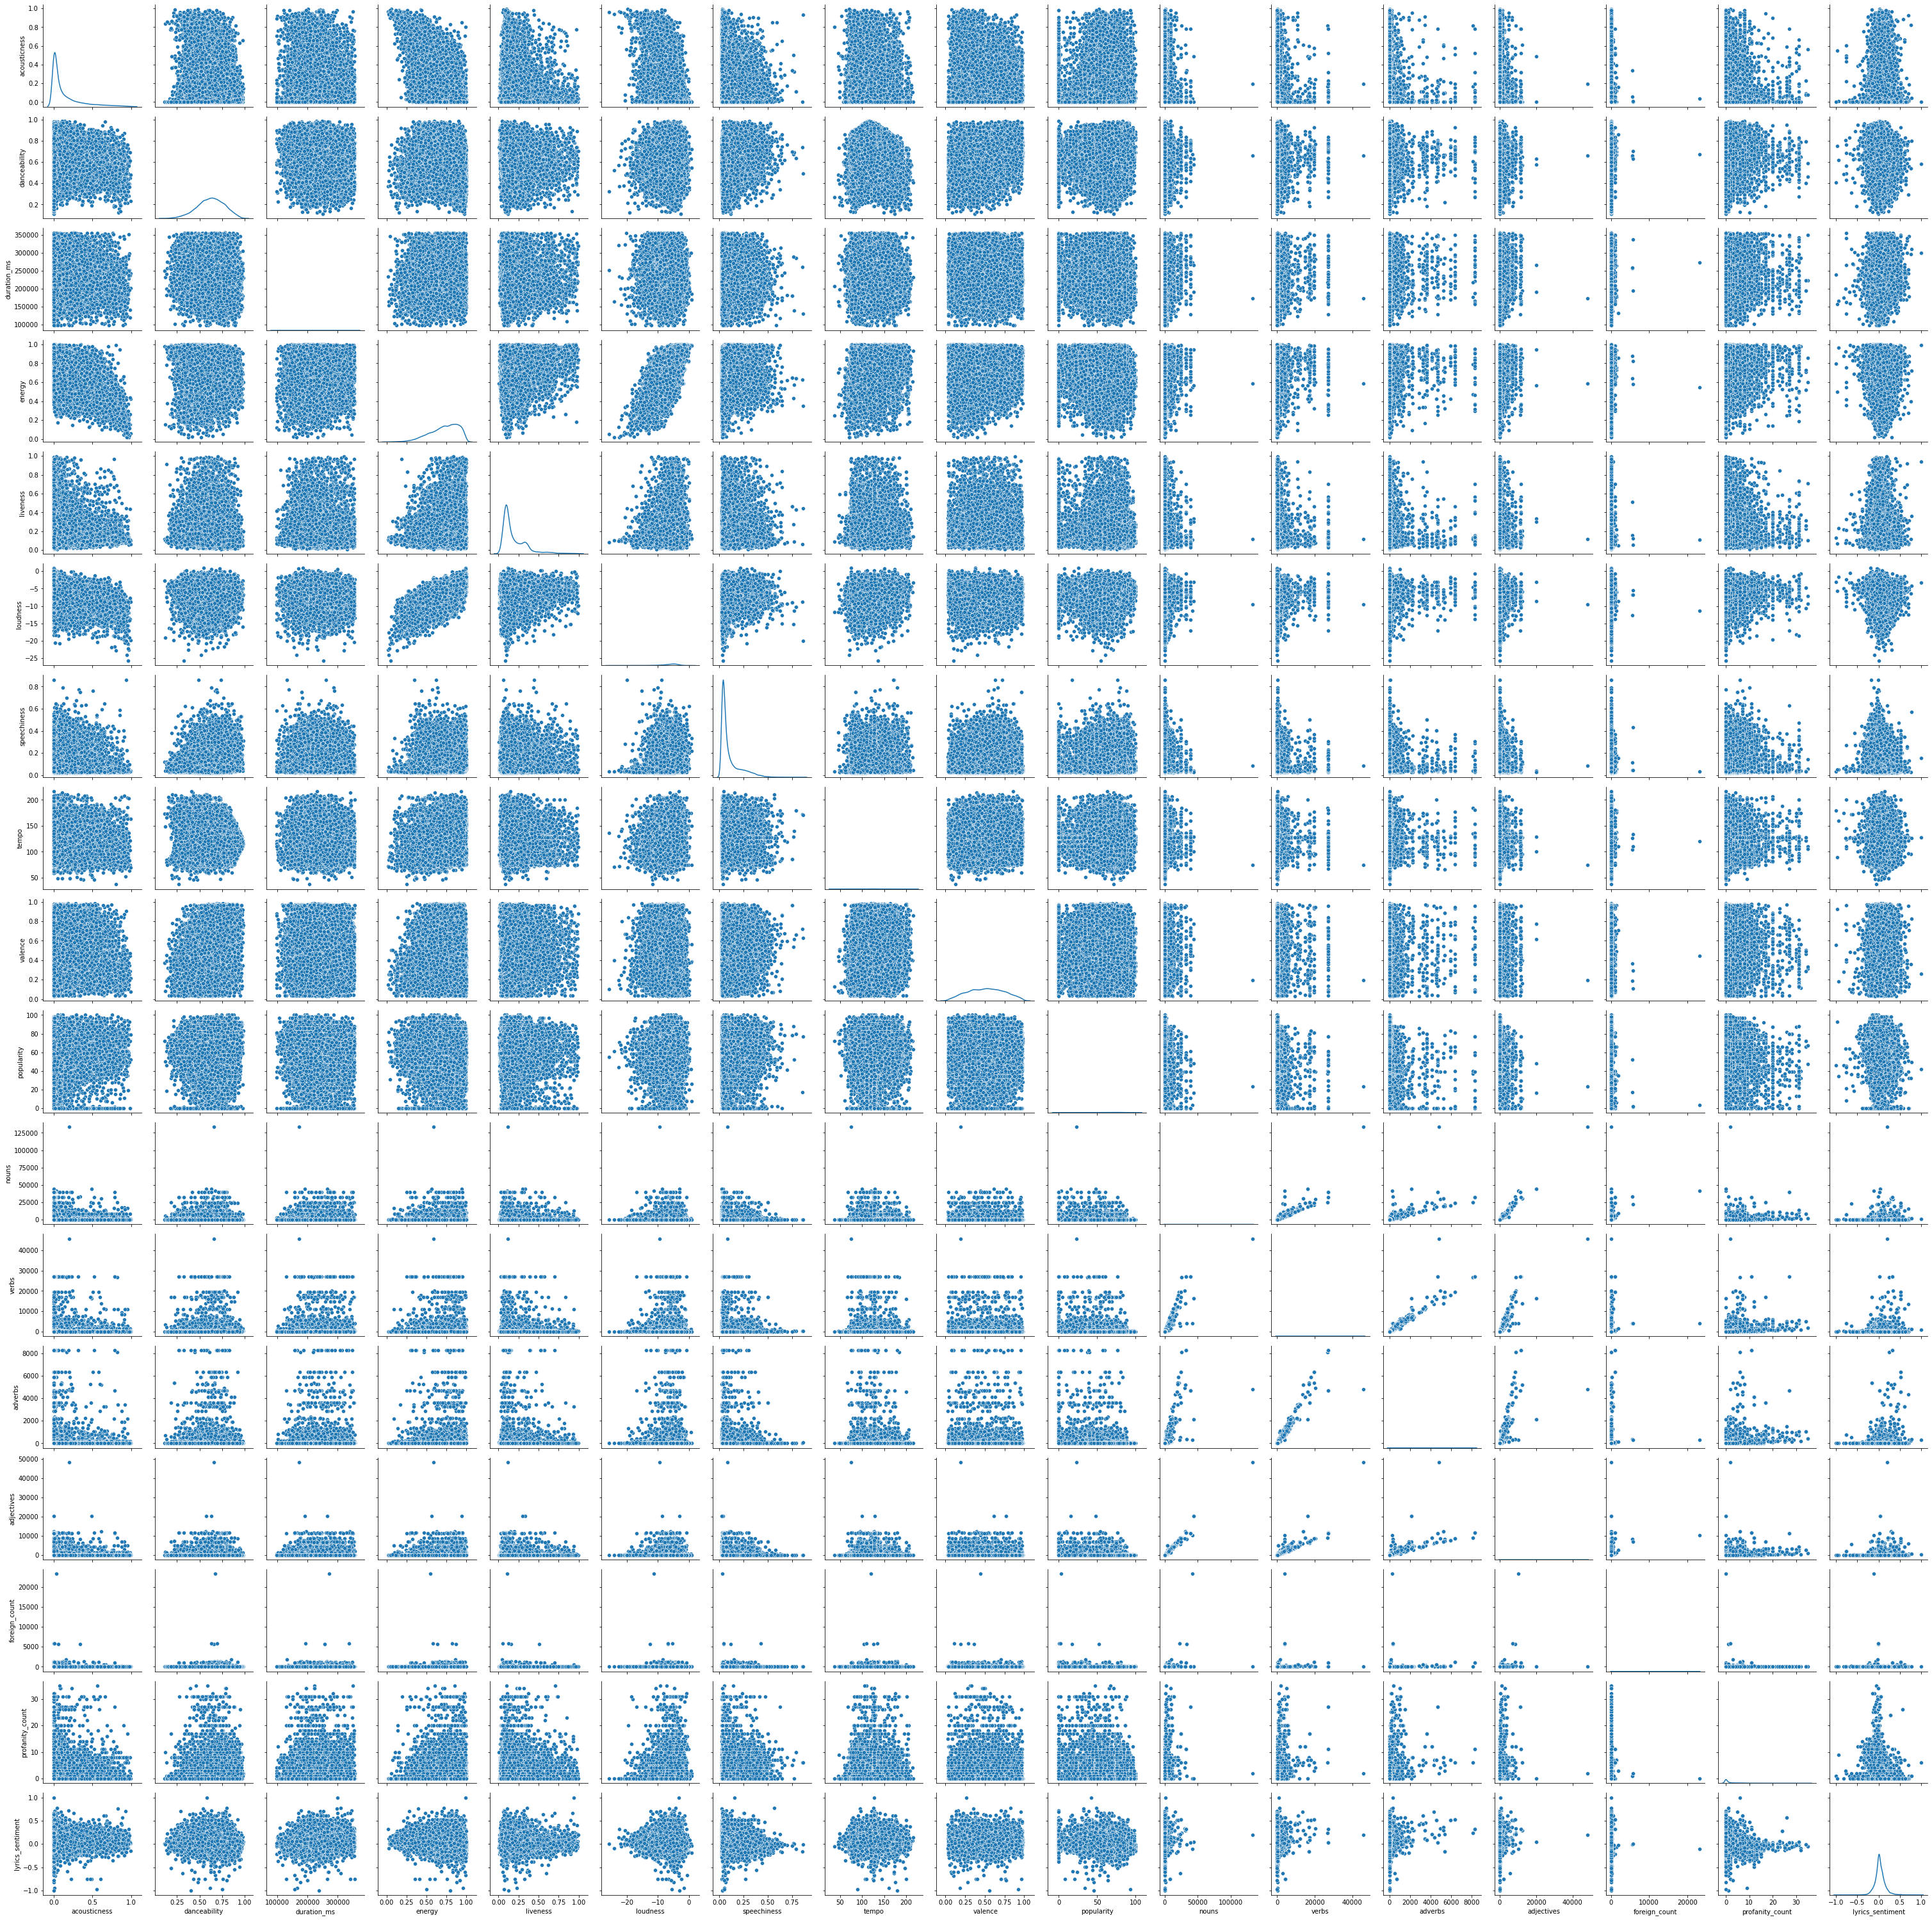

In [8]:
continuious_vars = ['acousticness', 'danceability','duration_ms', 'energy','liveness','loudness','speechiness','tempo','valence','popularity','nouns','verbs','adverbs','adjectives','foreign_count','profanity_count', 'lyrics_sentiment']
continuious_vars_pairs_plot = sns.PairGrid(spotify_df, vars = continuious_vars)
#continuious_vars_pairs_plot.map_diag(sns.kdeplot)
continuious_vars_pairs_plot.map_diag(sns.kdeplot)
continuious_vars_pairs_plot.map_offdiag(sns.scatterplot)
#continuious_vars_pairs_plot.fig.suptitle("Spotify Audio Features Pairs Plot")

Text(0.5, 1.0, 'Spotify Audio Features Correlation Matrix With Lyric Features')

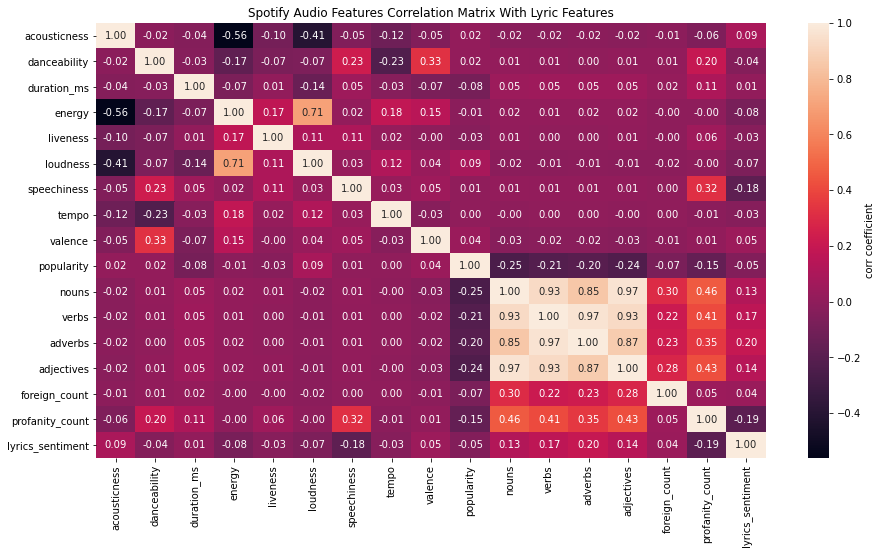

In [9]:
plt.figure(figsize=(15,8))
ax =sns.heatmap(spotify_df[continuious_vars].corr(),annot=True, fmt=".2f", cbar_kws={'label': 'corr coefficient'})
ax.set_title("Spotify Audio Features Correlation Matrix With Lyric Features")

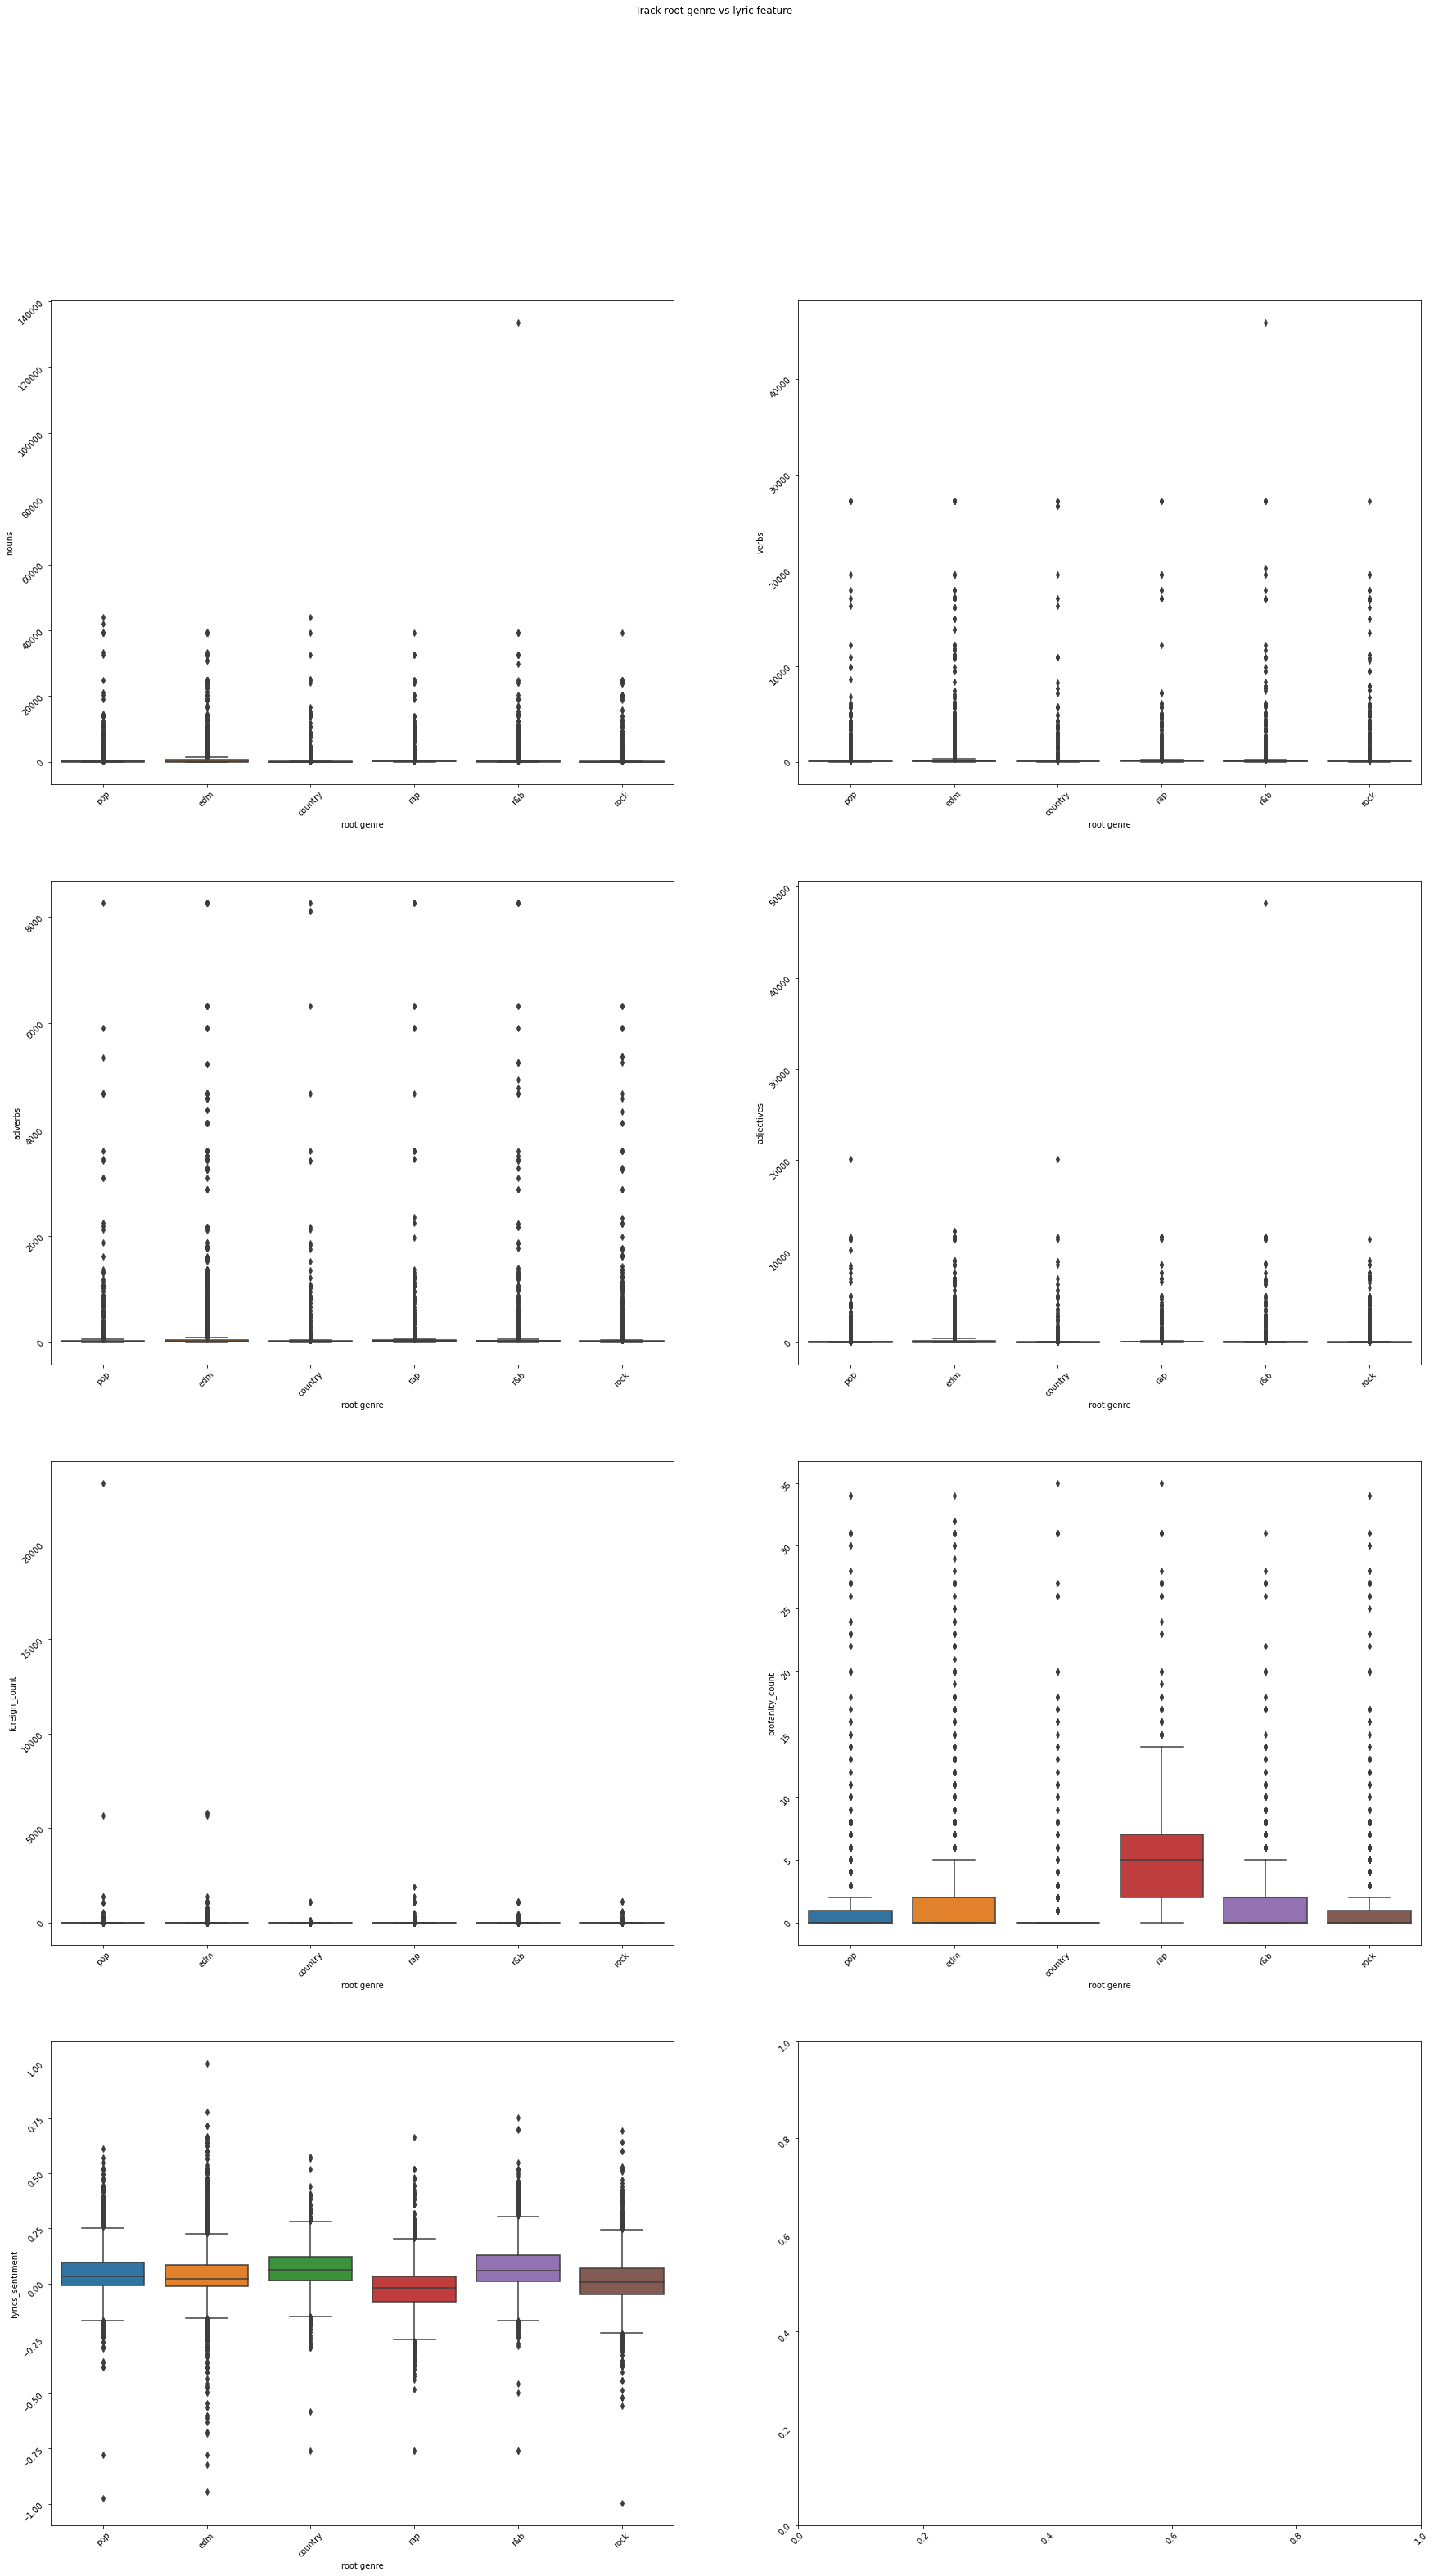

In [6]:
fig, axes = plt.subplots(4,2,figsize=(30, 50))
fig.suptitle("Track root genre vs lyric feature")

#nouns
plt1 = sns.boxplot(ax = axes[0,0],data = spotify_df, x = "root genre", y = 'nouns')

#verbs
plt2 = sns.boxplot(ax = axes[0,1],data = spotify_df, x = "root genre", y = 'verbs')

#adverbs
plt3 = sns.boxplot(ax = axes[1,0],data = spotify_df, x = "root genre", y = 'adverbs')

#adjectives
plt4 = sns.boxplot(ax = axes[1,1],data = spotify_df, x = "root genre", y = 'adjectives')

#foreign_count
plt5 = sns.boxplot(ax = axes[2,0],data = spotify_df, x = "root genre", y = 'foreign_count')

#profanity_count 
plt6 = sns.boxplot(ax = axes[2,1],data = spotify_df, x = "root genre", y = 'profanity_count')

#sentiment 
plt7 = sns.boxplot(ax = axes[3,0],data = spotify_df, x = "root genre", y = 'lyrics_sentiment')



for ax in fig.axes:
    ax.tick_params(labelrotation=45)

#### Key Obsevations 

 - Only the profanity count and lyrics sentiment seem useful for modeling as most other feautres are too simmialr among genres 

In [ ]:
spotify_features_list = ["acousticness","danceability","duration_ms","energy","instrumentalness","key","liveness","mode","speechiness","tempo","time_signature","valence","popularity",'nouns','verbs','adverbs','adjectives','foreign_count','profanity_count','nouns','verbs','adverbs','adjectives','foreign_count','profanity_count']
spotify_features_X  = spotify_df[spotify_features_list].values
spotify_targets_y = spotify_df['root genre'].values